In [13]:
"""
File that runs the actual reconstruction optimizer forward pass. 
It should compute 3 loss functions: contour chamfer loss, tip distance 
loss, and motion model loss. In its forward pass, it will call upon 
the construction_bezier and motion_catheter scripts to build its 
catheters. It will be optimizing the parameter para_init. 
"""
import sys
sys.path.append('..')
sys.path.insert(1, 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts')

import torch
import torch.nn as nn
import cv2
# from tqdm.notebook import tqdm
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

from construction_bezier import ConstructionBezier
from loss_define import (
    ContourChamferLoss, 
    TipDistanceLoss, 
    ImageContourChamferLoss, 
    GenerateRefData
)

from catheter_motion import CatheterMotion


class ReconstructionOptimizer(nn.Module): 

    def __init__(self, p_start, para_init, image_ref, gpu_or_cpu, past_frames_list, delta_u_list, img_save_path, image_save_path_list): 
        '''
        This function initializes the catheter optimization model.

        Args:
            p_start (tensor): starting point of the catheter
            image_ref (numpy array): reference image to compare to
            gpu_or_cpu (str): either 'cuda' or 'cpu'
        '''
        super().__init__()

        self.build_bezier = ConstructionBezier(radius=0.0005)
        self.build_bezier.to(gpu_or_cpu)
        self.build_bezier.loadRawImage(img_save_path)

        self.contour_chamfer_loss = ContourChamferLoss(device=gpu_or_cpu)
        self.contour_chamfer_loss.to(gpu_or_cpu)
        self.tip_distance_loss = TipDistanceLoss(device=gpu_or_cpu)
        self.tip_distance_loss.to(gpu_or_cpu)
        self.image_contour_chamfer_loss = ImageContourChamferLoss(device=gpu_or_cpu)
        self.image_contour_chamfer_loss.to(gpu_or_cpu)
        
        # Declare self.tip_euclidean_distance_loss as a variable that'll hold a single numpy scalar value
        self.tip_euclidean_distance_loss = None

        self.p_start = p_start.to(gpu_or_cpu).detach()
        self.para_init = nn.Parameter(torch.from_numpy(para_init).to(gpu_or_cpu),
                                      requires_grad=True)
        
        
        image_ref = torch.from_numpy(image_ref.astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Generate reference data, so you don't need to generate it in every forward pass
        self.generate_ref_data = GenerateRefData(self.image_ref)
        ref_catheter_contour = self.generate_ref_data.get_raw_contour()
        self.register_buffer('ref_catheter_contour', ref_catheter_contour)
        ref_catheter_centerline = self.generate_ref_data.get_raw_centerline()
        self.register_buffer('ref_catheter_centerline', ref_catheter_centerline)
        
        # self.register_buffer('delta_u_list', delta_u_list)
        self.delta_u_list = delta_u_list
        # self.register_buffer('past_frames_list', past_frames_list)
        # self.register_buffer('image_save_path_list', image_save_path_list)
        self.image_save_path_list = image_save_path_list
        
        # Generate reference data for past frames
        contour_list = []
        centerline_list = []
        for image in past_frames_list:
            image = torch.from_numpy(image.astype(np.float32))
            generate_ref_data = GenerateRefData(image)
            ref_catheter_contour = generate_ref_data.get_raw_contour()
            ref_catheter_centerline = generate_ref_data.get_raw_centerline()
            contour_list.append(ref_catheter_contour)
            centerline_list.append(ref_catheter_centerline)
        # self.register_buffer('contour_list', torch.stack(contour_list))
        # self.register_buffer('centerline_list', torch.stack(centerline_list))
        self.contour_list = contour_list
        self.centerline_list = centerline_list
        
        self.gpu_or_cpu = gpu_or_cpu

    def forward(self, save_img_path): 
        '''
        Function to run forward pass of the catheter optimization model.
        Creates catheter model, gets projection onto 2d image, and calculates loss.

        Args:
            save_img_path (str): path to save the projection image to
        '''

        # print('hello')
        
        # Generate the Bezier curve cylinder mesh points
        self.build_bezier.getBezierCurveCylinder(self.p_start, self.para_init)

        # Get 2d projected Bezier Cylinder mesh points
        self.build_bezier.getCylinderMeshProjImg()

        # Get 2d projected Bezier centerline (position) points
        self.build_bezier.getBezierProjImg()

        self.build_bezier.draw2DCylinderImage(self.image_ref, save_img_path)

        loss_contour = self.contour_chamfer_loss(self.build_bezier.bezier_proj_img.to(self.gpu_or_cpu), self.ref_catheter_contour.to(self.gpu_or_cpu))

        loss_tip_distance, self.tip_euclidean_distance_loss = self.tip_distance_loss(self.build_bezier.bezier_proj_centerline_img.to(self.gpu_or_cpu), self.ref_catheter_centerline.to(self.gpu_or_cpu))
        
        p0 = self.p_start.detach().cpu().numpy()
        para_init = self.para_init.detach().cpu().numpy()
        catheterMotion = CatheterMotion(p0)
        predicted_paras = catheterMotion.past_frames_prediction(self.delta_u_list, para_init)
        motion_model_loss = torch.tensor(0.0).to(self.gpu_or_cpu)
        for i in range(len(predicted_paras)):
            build_bezier = ConstructionBezier()
            build_bezier.to(self.gpu_or_cpu)
            build_bezier.loadRawImage(self.image_save_path_list[i])
            build_bezier.getBezierCurveCylinder(self.p_start, torch.from_numpy(predicted_paras[i]).to(self.gpu_or_cpu))
            build_bezier.getCylinderMeshProjImg()
            build_bezier.getBezierProjImg()
            # build_bezier.draw2DCylinderImage(self.past_frames_list[i], save_img_path_list[i])
            
            loss_contour = self.contour_chamfer_loss(build_bezier.bezier_proj_img.to(self.gpu_or_cpu), self.contour_list[i].to(self.gpu_or_cpu))
            motion_model_loss += loss_contour.to(self.gpu_or_cpu)  
            
        
        weight = torch.tensor([1.0, 1.0, 1.0])
        loss = loss_contour * weight[0] + loss_tip_distance * weight[1] + motion_model_loss * weight[2]


        print("-----------------------------------------------------------------")
        print("loss_contour: ", loss_contour)
        # print("loss_tip: ", loss_tip)
        # print("loss_boundary: ", loss_boundary)
        print("loss_tip_distance: ", loss_tip_distance)
        # print("loss_boundary_point_distance_loss: ", loss_boundary_point_distance_loss)
        print("motion_model_loss: ", motion_model_loss)
        print("loss: ", loss)
        print("-----------------------------------------------------------------")


        # TODO: Plot the loss

        return loss
    





In [14]:
def process_image(img_save_path):
    img_ref_rgb = cv2.imread(img_save_path)
    img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 80, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    
    return img_ref_binary

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<01:59,  1.20s/it, loss=5.32e+9]

-----------------------------------------------------------------
loss_contour:  tensor(23330729.1311, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1417.8130, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(5.2961e+09, device='cuda:0')
loss:  tensor(5.3194e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 261281.546875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0260, -0.0466,  0.1900], device='cuda:0')
Loss:  5319408434.944079

loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<01:56,  1.18s/it, loss=1.04e+9]

-----------------------------------------------------------------
loss_contour:  tensor(15068955.2951, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(118.3332, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.0210e+09, device='cuda:0')
loss:  tensor(1.0361e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 71810.203125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0222, -0.0528,  0.1885], device='cuda:0')
Loss:  1036064657.628377

loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<01:59,  1.23s/it, loss=9.85e+7]

-----------------------------------------------------------------
loss_contour:  tensor(13288615.1027, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1067.6151, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(85226184., device='cuda:0')
loss:  tensor(98515866.7178, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 218050.171875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0235, -0.0519,  0.1941], device='cuda:0')
Loss:  98515866.71781714

loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:03,  1.29s/it, loss=1.02e+8]

-----------------------------------------------------------------
loss_contour:  tensor(13222889.1355, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(676.0074, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(89268560., device='cuda:0')
loss:  tensor(1.0249e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 167608.75
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0271, -0.0490,  0.2006], device='cuda:0')
Loss:  102492125.14296153

loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:01,  1.28s/it, loss=1.02e+8]

-----------------------------------------------------------------
loss_contour:  tensor(24285021.2621, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(143.5769, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(77597840., device='cuda:0')
loss:  tensor(1.0188e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 75043.6640625
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0314, -0.0463,  0.2044], device='cuda:0')
Loss:  101883004.83901742

loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:08<02:17,  1.46s/it, loss=2.21e+8]

-----------------------------------------------------------------
loss_contour:  tensor(92092751.1009, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(96.0063, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.2898e+08, device='cuda:0')
loss:  tensor(2.2107e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 61450.41796875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0351, -0.0453,  0.2052], device='cuda:0')
Loss:  221073719.10724223

loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:07,  1.37s/it, loss=1.33e+8]

-----------------------------------------------------------------
loss_contour:  tensor(31331724.2571, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(293.5876, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.0174e+08, device='cuda:0')
loss:  tensor(1.3307e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 104491.9296875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0372, -0.0460,  0.2049], device='cuda:0')
Loss:  133071193.84465742

loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:02,  1.33s/it, loss=1.04e+8]

-----------------------------------------------------------------
loss_contour:  tensor(22773808.2598, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(422.6708, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(80952744., device='cuda:0')
loss:  tensor(1.0373e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 125365.4453125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0374, -0.0478,  0.2052], device='cuda:0')
Loss:  103726974.93064415

loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:11<01:57,  1.29s/it, loss=7.01e+7]

-----------------------------------------------------------------
loss_contour:  tensor(15633298.0424, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(345.4670, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(54440468., device='cuda:0')
loss:  tensor(70074111.5094, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 113693.6484375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0360, -0.0500,  0.2069], device='cuda:0')
Loss:  70074111.50941291

loop_id:  9


Optimizing:  10%|█         | 10/100 [00:12<01:53,  1.26s/it, loss=8.77e+7]

-----------------------------------------------------------------
loss_contour:  tensor(14323206.0466, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(155.4384, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(73392064., device='cuda:0')
loss:  tensor(87715425.4850, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 76262.125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0337, -0.0520,  0.2100], device='cuda:0')
Loss:  87715425.48502925

loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<01:52,  1.26s/it, loss=2.52e+8]

-----------------------------------------------------------------
loss_contour:  tensor(41624905.1971, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(28.3526, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.1039e+08, device='cuda:0')
loss:  tensor(2.5202e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 32887.44921875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0314, -0.0535,  0.2137], device='cuda:0')
Loss:  252018853.5497724

loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:15<01:47,  1.23s/it, loss=2.62e+8]

-----------------------------------------------------------------
loss_contour:  tensor(1.1356e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(43.8989, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.4809e+08, device='cuda:0')
loss:  tensor(2.6165e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 38847.65234375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0296, -0.0543,  0.2175], device='cuda:0')
Loss:  261653347.08621556

loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:16<01:46,  1.23s/it, loss=6.37e+10]

-----------------------------------------------------------------
loss_contour:  tensor(14298326.2681, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(144.1976, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(6.3661e+10, device='cuda:0')
loss:  tensor(6.3676e+10, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 68984.78125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0289, -0.0546,  0.2206], device='cuda:0')
Loss:  63675641190.46573

loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:17<01:45,  1.23s/it, loss=9.7e+7]  

-----------------------------------------------------------------
loss_contour:  tensor(22862401.5960, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(214.2275, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(74162640., device='cuda:0')
loss:  tensor(97025255.8235, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 83086.328125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0294, -0.0545,  0.2226], device='cuda:0')
Loss:  97025255.82351544

loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:19<01:44,  1.23s/it, loss=8.9e+7]

-----------------------------------------------------------------
loss_contour:  tensor(30141049.1896, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(191.8498, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(58896840., device='cuda:0')
loss:  tensor(89038081.0394, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 78099.0390625
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0308, -0.0543,  0.2235], device='cuda:0')
Loss:  89038081.03935775

loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:20<01:48,  1.29s/it, loss=7.47e+7]

-----------------------------------------------------------------
loss_contour:  tensor(16034328.6095, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(102.8651, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(58662060., device='cuda:0')
loss:  tensor(74696491.4746, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 57117.24609375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0328, -0.0541,  0.2234], device='cuda:0')
Loss:  74696491.47461519

loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:21<01:44,  1.26s/it, loss=3.15e+8]

-----------------------------------------------------------------
loss_contour:  tensor(1.4043e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(20.4103, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.7495e+08, device='cuda:0')
loss:  tensor(3.1537e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 25534.537109375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0349, -0.0539,  0.2229], device='cuda:0')
Loss:  315372958.36306304

loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:22<01:40,  1.23s/it, loss=1.02e+8]

-----------------------------------------------------------------
loss_contour:  tensor(24694558.8220, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(2.8890, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(77334360., device='cuda:0')
loss:  tensor(1.0203e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 9592.791015625
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0367, -0.0538,  0.2225], device='cuda:0')
Loss:  102028921.71096535

loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:24<01:41,  1.25s/it, loss=3.21e+9]

-----------------------------------------------------------------
loss_contour:  tensor(16932286.1565, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(48.1506, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.1888e+09, device='cuda:0')
loss:  tensor(3.2058e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 39371.2421875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0379, -0.0537,  0.2229], device='cuda:0')
Loss:  3205776622.307102

loop_id:  19


Optimizing:  20%|██        | 20/100 [00:25<01:39,  1.25s/it, loss=1.25e+8]

-----------------------------------------------------------------
loss_contour:  tensor(13805449.3925, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(99.0414, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.1155e+08, device='cuda:0')
loss:  tensor(1.2536e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 56334.78515625
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0382, -0.0537,  0.2242], device='cuda:0')
Loss:  125359108.43388605

loop_id:  20


Optimizing:  21%|██        | 21/100 [00:26<01:38,  1.25s/it, loss=1.03e+8]

-----------------------------------------------------------------
loss_contour:  tensor(23315231.2358, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(104.7655, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(79818816., device='cuda:0')
loss:  tensor(1.0313e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 57442.1640625
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0377, -0.0539,  0.2262], device='cuda:0')
Loss:  103134152.00124545

loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:27<01:36,  1.24s/it, loss=3.62e+8]

-----------------------------------------------------------------
loss_contour:  tensor(1.6319e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(67.4719, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.9889e+08, device='cuda:0')
loss:  tensor(3.6209e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 45486.28515625
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0367, -0.0543,  0.2285], device='cuda:0')
Loss:  362087493.52483964

loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:29<01:36,  1.25s/it, loss=5.79e+8]

-----------------------------------------------------------------
loss_contour:  tensor(2.6964e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(24.3504, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.0944e+08, device='cuda:0')
loss:  tensor(5.7908e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 26966.474609375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0354, -0.0550,  0.2306], device='cuda:0')
Loss:  579084511.5116818

loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:30<01:35,  1.25s/it, loss=8.97e+7]

-----------------------------------------------------------------
loss_contour:  tensor(24372619.9807, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(5.4851, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(65374880., device='cuda:0')
loss:  tensor(89747505.4658, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 13073.1689453125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0344, -0.0559,  0.2320], device='cuda:0')
Loss:  89747505.46580476

loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:31<01:32,  1.24s/it, loss=9.36e+7]

-----------------------------------------------------------------
loss_contour:  tensor(18982045.0051, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(14.6380, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(74657760., device='cuda:0')
loss:  tensor(93639819.6431, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 21010.13671875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0336, -0.0568,  0.2328], device='cuda:0')
Loss:  93639819.64313558

loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:32<01:31,  1.24s/it, loss=1.76e+8]

-----------------------------------------------------------------
loss_contour:  tensor(72443837.8114, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(36.2825, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.0404e+08, device='cuda:0')
loss:  tensor(1.7648e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 32486.205078125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0334, -0.0575,  0.2331], device='cuda:0')
Loss:  176483514.09389046

loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:34<01:33,  1.28s/it, loss=1.05e+8]

-----------------------------------------------------------------
loss_contour:  tensor(14009694.5921, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(50.8837, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(90506376., device='cuda:0')
loss:  tensor(1.0452e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 38241.2578125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0337, -0.0579,  0.2332], device='cuda:0')
Loss:  104516121.47578573

loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:35<01:30,  1.26s/it, loss=1.11e+8]

-----------------------------------------------------------------
loss_contour:  tensor(28294387.6372, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(47.0046, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(82947576., device='cuda:0')
loss:  tensor(1.1124e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 36709.19140625
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0345, -0.0578,  0.2333], device='cuda:0')
Loss:  111242010.64185137

loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:36<01:34,  1.33s/it, loss=2.18e+9]

-----------------------------------------------------------------
loss_contour:  tensor(15643363.2414, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(27.5113, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.1652e+09, device='cuda:0')
loss:  tensor(2.1808e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 28107.470703125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0354, -0.0574,  0.2336], device='cuda:0')
Loss:  2180803582.7526526

loop_id:  29


Optimizing:  30%|███       | 30/100 [00:38<01:30,  1.29s/it, loss=4.35e+8]

-----------------------------------------------------------------
loss_contour:  tensor(13085414.4081, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(7.2117, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(4.2165e+08, device='cuda:0')
loss:  tensor(4.3474e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 14453.4375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0364, -0.0569,  0.2341], device='cuda:0')
Loss:  434736013.61974096

loop_id:  30


Optimizing:  31%|███       | 31/100 [00:39<01:26,  1.25s/it, loss=6.73e+7]

-----------------------------------------------------------------
loss_contour:  tensor(14315196.4032, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.9680, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(52957572., device='cuda:0')
loss:  tensor(67272769.3712, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5384.46923828125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0372, -0.0563,  0.2347], device='cuda:0')
Loss:  67272769.37118934

loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:40<01:24,  1.24s/it, loss=1.3e+9] 

-----------------------------------------------------------------
loss_contour:  tensor(14274516.5239, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(10.7776, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.2887e+09, device='cuda:0')
loss:  tensor(1.3030e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 17475.591796875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0378, -0.0559,  0.2353], device='cuda:0')
Loss:  1302974047.301477

loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:41<01:21,  1.22s/it, loss=7.46e+7]

-----------------------------------------------------------------
loss_contour:  tensor(20199313.9442, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(24.5514, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(54366056., device='cuda:0')
loss:  tensor(74565394.4956, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 26302.3046875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0379, -0.0559,  0.2358], device='cuda:0')
Loss:  74565394.49556828

loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:42<01:19,  1.21s/it, loss=1.77e+8]

-----------------------------------------------------------------
loss_contour:  tensor(64697571.4223, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(28.3051, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.1214e+08, device='cuda:0')
loss:  tensor(1.7684e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 28182.572265625
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0377, -0.0563,  0.2362], device='cuda:0')
Loss:  176838639.7273698

loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:44<01:22,  1.27s/it, loss=1.03e+8]

-----------------------------------------------------------------
loss_contour:  tensor(14244067.5644, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(19.1316, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(89156472., device='cuda:0')
loss:  tensor(1.0340e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 23128.033203125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0373, -0.0569,  0.2365], device='cuda:0')
Loss:  103400558.69603945

loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:45<01:20,  1.26s/it, loss=1.35e+8]

-----------------------------------------------------------------
loss_contour:  tensor(12994189.6967, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(6.1921, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.2224e+08, device='cuda:0')
loss:  tensor(1.3524e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 13142.4052734375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0367, -0.0576,  0.2369], device='cuda:0')
Loss:  135239083.8887702

loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:46<01:20,  1.28s/it, loss=2.78e+8]

-----------------------------------------------------------------
loss_contour:  tensor(1.1426e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.3707, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.6345e+08, device='cuda:0')
loss:  tensor(2.7771e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3328.25048828125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0361, -0.0581,  0.2373], device='cuda:0')
Loss:  277706793.08407414

loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:47<01:17,  1.25s/it, loss=1.43e+9]

-----------------------------------------------------------------
loss_contour:  tensor(13285429.7998, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(4.1621, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.4129e+09, device='cuda:0')
loss:  tensor(1.4262e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 10788.310546875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0357, -0.0585,  0.2379], device='cuda:0')
Loss:  1426192185.9619784

loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:49<01:15,  1.24s/it, loss=1.3e+9] 

-----------------------------------------------------------------
loss_contour:  tensor(13813129.8495, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(11.3081, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.2827e+09, device='cuda:0')
loss:  tensor(1.2965e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 17665.82421875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0355, -0.0585,  0.2385], device='cuda:0')
Loss:  1296547733.157618

loop_id:  39


Optimizing:  40%|████      | 40/100 [00:50<01:15,  1.25s/it, loss=9.61e+7]

-----------------------------------------------------------------
loss_contour:  tensor(19655123.9114, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(14.4177, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(76487928., device='cuda:0')
loss:  tensor(96143066.3292, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 19880.048828125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0356, -0.0584,  0.2391], device='cuda:0')
Loss:  96143066.3291615

loop_id:  40


Optimizing:  41%|████      | 41/100 [00:51<01:11,  1.21s/it, loss=1.05e+8]

-----------------------------------------------------------------
loss_contour:  tensor(13969629.1951, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(11.3859, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(91355264., device='cuda:0')
loss:  tensor(1.0532e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 17657.591796875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0360, -0.0581,  0.2394], device='cuda:0')
Loss:  105324904.58103698

loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:52<01:09,  1.19s/it, loss=8.56e+7]

-----------------------------------------------------------------
loss_contour:  tensor(14770868.7291, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(5.4286, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(70829488., device='cuda:0')
loss:  tensor(85600362.1576, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 12260.0712890625
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0365, -0.0578,  0.2395], device='cuda:0')
Loss:  85600362.1576463

loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:54<01:10,  1.24s/it, loss=1.47e+8]

-----------------------------------------------------------------
loss_contour:  tensor(13135590.8018, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1.2196, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.3376e+08, device='cuda:0')
loss:  tensor(1.4689e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5948.8232421875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0371, -0.0576,  0.2393], device='cuda:0')
Loss:  146891552.0214074

loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:55<01:08,  1.23s/it, loss=7.09e+8]

-----------------------------------------------------------------
loss_contour:  tensor(3.3630e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1.3346, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.7224e+08, device='cuda:0')
loss:  tensor(7.0853e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6067.94140625
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0376, -0.0576,  0.2390], device='cuda:0')
Loss:  708533669.1185373

loop_id:  44


Optimizing:  45%|████▌     | 45/100 [00:56<01:13,  1.34s/it, loss=4.65e+8]

-----------------------------------------------------------------
loss_contour:  tensor(2.1497e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(4.7178, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.5025e+08, device='cuda:0')
loss:  tensor(4.6522e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 11355.4931640625
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0378, -0.0577,  0.2389], device='cuda:0')
Loss:  465219253.31781054

loop_id:  45


Optimizing:  46%|████▌     | 46/100 [00:58<01:09,  1.29s/it, loss=8.95e+7]

-----------------------------------------------------------------
loss_contour:  tensor(23958960.3860, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(7.6418, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(65539372., device='cuda:0')
loss:  tensor(89498340.0277, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 14520.5380859375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0378, -0.0578,  0.2390], device='cuda:0')
Loss:  89498340.02772766

loop_id:  46


Optimizing:  47%|████▋     | 47/100 [00:59<01:06,  1.25s/it, loss=1.03e+8]

-----------------------------------------------------------------
loss_contour:  tensor(14808092.2521, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(7.0010, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(87744936., device='cuda:0')
loss:  tensor(1.0255e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 13941.5751953125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0376, -0.0580,  0.2393], device='cuda:0')
Loss:  102553035.2531795

loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:00<01:05,  1.26s/it, loss=8.66e+7]

-----------------------------------------------------------------
loss_contour:  tensor(20782163.4503, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(3.3804, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(65782512., device='cuda:0')
loss:  tensor(86564678.8307, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 9694.703125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0372, -0.0581,  0.2398], device='cuda:0')
Loss:  86564678.83073774

loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:01<01:03,  1.24s/it, loss=1.34e+8]

-----------------------------------------------------------------
loss_contour:  tensor(12977829.6796, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.3531, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.2060e+08, device='cuda:0')
loss:  tensor(1.3358e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3131.253173828125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0368, -0.0583,  0.2404], device='cuda:0')
Loss:  133582278.03274865

loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:02<01:03,  1.26s/it, loss=1.02e+8]

-----------------------------------------------------------------
loss_contour:  tensor(15314869.9232, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.4945, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(86716016., device='cuda:0')
loss:  tensor(1.0203e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3688.886474609375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0364, -0.0584,  0.2408], device='cuda:0')
Loss:  102030886.41771932

loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:04<01:02,  1.27s/it, loss=7.68e+7]

-----------------------------------------------------------------
loss_contour:  tensor(21155224.2742, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(2.8150, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(55648424., device='cuda:0')
loss:  tensor(76803651.0892, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 8779.3134765625
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0363, -0.0585,  0.2410], device='cuda:0')
Loss:  76803651.08921185

loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:05<01:00,  1.25s/it, loss=1.2e+8] 

-----------------------------------------------------------------
loss_contour:  tensor(13106374.7292, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(4.3729, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.0676e+08, device='cuda:0')
loss:  tensor(1.1987e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 10911.33984375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0364, -0.0586,  0.2410], device='cuda:0')
Loss:  119867611.10204397

loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:06<00:59,  1.27s/it, loss=9.81e+7]

-----------------------------------------------------------------
loss_contour:  tensor(24269732.1473, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(3.6191, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(73821976., device='cuda:0')
loss:  tensor(98091711.7664, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 9897.6708984375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0367, -0.0586,  0.2408], device='cuda:0')
Loss:  98091711.766384

loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:08<00:57,  1.26s/it, loss=2.21e+8]

-----------------------------------------------------------------
loss_contour:  tensor(89446865.4571, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1.5895, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.3130e+08, device='cuda:0')
loss:  tensor(2.2075e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6540.4365234375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0370, -0.0585,  0.2406], device='cuda:0')
Loss:  220748139.04663762

loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:09<00:55,  1.24s/it, loss=1.11e+8]

-----------------------------------------------------------------
loss_contour:  tensor(13283829.6309, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.2699, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(97485896., device='cuda:0')
loss:  tensor(1.1077e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2735.679443359375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0373, -0.0584,  0.2405], device='cuda:0')
Loss:  110769725.90079051

loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:10<00:55,  1.27s/it, loss=1.97e+9]

-----------------------------------------------------------------
loss_contour:  tensor(14963564.2667, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.5193, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.9591e+09, device='cuda:0')
loss:  tensor(1.9741e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3829.078125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0375, -0.0582,  0.2406], device='cuda:0')
Loss:  1974053740.7859628

loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:11<00:53,  1.24s/it, loss=1.33e+9]

-----------------------------------------------------------------
loss_contour:  tensor(47261999.5584, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1.6210, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.2808e+09, device='cuda:0')
loss:  tensor(1.3280e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6651.7177734375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0376, -0.0581,  0.2408], device='cuda:0')
Loss:  1328029489.1794212

loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:12<00:52,  1.24s/it, loss=1.21e+8]

-----------------------------------------------------------------
loss_contour:  tensor(26451479.6271, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(2.2975, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(94347192., device='cuda:0')
loss:  tensor(1.2080e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 7871.82080078125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0376, -0.0581,  0.2410], device='cuda:0')
Loss:  120798673.92461586

loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:14<00:51,  1.25s/it, loss=1.05e+8]

-----------------------------------------------------------------
loss_contour:  tensor(22961241.4258, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1.8836, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(82352400., device='cuda:0')
loss:  tensor(1.0531e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 7112.22021484375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0374, -0.0582,  0.2412], device='cuda:0')
Loss:  105313643.30940446

loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:15<00:49,  1.23s/it, loss=1.11e+8]

-----------------------------------------------------------------
loss_contour:  tensor(13270749.9224, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.7952, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(97959320., device='cuda:0')
loss:  tensor(1.1123e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4628.619140625
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0372, -0.0584,  0.2413], device='cuda:0')
Loss:  111230070.717657

loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:16<00:48,  1.25s/it, loss=1.23e+8]

-----------------------------------------------------------------
loss_contour:  tensor(13029012.4840, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0734, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.0962e+08, device='cuda:0')
loss:  tensor(1.2265e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1443.18115234375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0370, -0.0586,  0.2413], device='cuda:0')
Loss:  122645924.5573891

loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:18<00:47,  1.26s/it, loss=8.64e+8]

-----------------------------------------------------------------
loss_contour:  tensor(13126829.9944, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.3289, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(8.5059e+08, device='cuda:0')
loss:  tensor(8.6372e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2971.54345703125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0368, -0.0587,  0.2414], device='cuda:0')
Loss:  863718190.3232937

loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:19<00:46,  1.25s/it, loss=2.51e+8]

-----------------------------------------------------------------
loss_contour:  tensor(15679542.5172, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1.0889, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.3541e+08, device='cuda:0')
loss:  tensor(2.5109e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5399.2060546875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0368, -0.0588,  0.2414], device='cuda:0')
Loss:  251085319.60606903

loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:20<00:45,  1.25s/it, loss=9.36e+8]

-----------------------------------------------------------------
loss_contour:  tensor(13273912.9794, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1.3715, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(9.2270e+08, device='cuda:0')
loss:  tensor(9.3597e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6060.35888671875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0369, -0.0587,  0.2414], device='cuda:0')
Loss:  935973754.3508618

loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:22<00:46,  1.34s/it, loss=4.31e+8]

-----------------------------------------------------------------
loss_contour:  tensor(13098555.2057, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.8605, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(4.1741e+08, device='cuda:0')
loss:  tensor(4.3051e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4798.3349609375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0370, -0.0586,  0.2415], device='cuda:0')
Loss:  430507708.06622493

loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:23<00:45,  1.35s/it, loss=1.59e+8]

-----------------------------------------------------------------
loss_contour:  tensor(13431608.0704, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.1884, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.4517e+08, device='cuda:0')
loss:  tensor(1.5861e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2247.001708984375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0372, -0.0585,  0.2415], device='cuda:0')
Loss:  158605160.25880188

loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:24<00:43,  1.31s/it, loss=8.07e+7]

-----------------------------------------------------------------
loss_contour:  tensor(25505232.6577, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0481, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(55226076., device='cuda:0')
loss:  tensor(80731308.7057, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1157.795166015625
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0374, -0.0584,  0.2415], device='cuda:0')
Loss:  80731308.70573439

loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:25<00:40,  1.28s/it, loss=9.95e+7]

-----------------------------------------------------------------
loss_contour:  tensor(13173708.2206, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.4063, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(86362040., device='cuda:0')
loss:  tensor(99535748.6270, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3302.2333984375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0375, -0.0583,  0.2415], device='cuda:0')
Loss:  99535748.62697515

loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:27<00:39,  1.28s/it, loss=4.81e+8]

-----------------------------------------------------------------
loss_contour:  tensor(13223487.6898, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.7242, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(4.6772e+08, device='cuda:0')
loss:  tensor(4.8094e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4400.970703125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0375, -0.0584,  0.2414], device='cuda:0')
Loss:  480941920.4139863

loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:28<00:37,  1.26s/it, loss=1.35e+8]

-----------------------------------------------------------------
loss_contour:  tensor(13006811.2753, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.6521, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.2226e+08, device='cuda:0')
loss:  tensor(1.3526e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4183.27783203125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0374, -0.0585,  0.2414], device='cuda:0')
Loss:  135263667.92742214

loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:29<00:36,  1.27s/it, loss=1.95e+9]

-----------------------------------------------------------------
loss_contour:  tensor(9.4172e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.3134, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.0055e+09, device='cuda:0')
loss:  tensor(1.9472e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2919.8994140625
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0373, -0.0586,  0.2415], device='cuda:0')
Loss:  1947209832.913868

loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:30<00:35,  1.26s/it, loss=2.36e+9]

-----------------------------------------------------------------
loss_contour:  tensor(32026970.1884, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0577, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.3285e+09, device='cuda:0')
loss:  tensor(2.3605e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1285.9022216796875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0371, -0.0586,  0.2416], device='cuda:0')
Loss:  2360492122.246129

loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:32<00:33,  1.24s/it, loss=1.29e+8]

-----------------------------------------------------------------
loss_contour:  tensor(45681444.8069, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0951, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(83799912., device='cuda:0')
loss:  tensor(1.2948e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1597.9310302734375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0370, -0.0587,  0.2417], device='cuda:0')
Loss:  129481356.9020384

loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:33<00:32,  1.27s/it, loss=7.7e+8] 

-----------------------------------------------------------------
loss_contour:  tensor(13084499.5895, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.3200, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(7.5706e+08, device='cuda:0')
loss:  tensor(7.7014e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2927.166259765625
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0370, -0.0587,  0.2418], device='cuda:0')
Loss:  770140691.9094524

loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:34<00:31,  1.25s/it, loss=2.7e+8]

-----------------------------------------------------------------
loss_contour:  tensor(42559920.8828, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.4374, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.2731e+08, device='cuda:0')
loss:  tensor(2.6987e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3435.20703125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0370, -0.0586,  0.2418], device='cuda:0')
Loss:  269867201.3202442

loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:35<00:29,  1.24s/it, loss=1.54e+8]

-----------------------------------------------------------------
loss_contour:  tensor(52165033.2129, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.2959, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.0226e+08, device='cuda:0')
loss:  tensor(1.5442e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2834.29345703125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0371, -0.0586,  0.2418], device='cuda:0')
Loss:  154421057.50886053

loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:37<00:28,  1.25s/it, loss=9.91e+7]

-----------------------------------------------------------------
loss_contour:  tensor(19052568.3971, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0652, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(80073264., device='cuda:0')
loss:  tensor(99125832.4623, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1333.1824951171875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0373, -0.0586,  0.2417], device='cuda:0')
Loss:  99125832.4622658

loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:38<00:27,  1.23s/it, loss=4.43e+8]

-----------------------------------------------------------------
loss_contour:  tensor(1.7972e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0093, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.6319e+08, device='cuda:0')
loss:  tensor(4.4291e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 502.2377014160156
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0374, -0.0585,  0.2416], device='cuda:0')
Loss:  442906690.7274778

loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:39<00:25,  1.23s/it, loss=1.56e+8]

-----------------------------------------------------------------
loss_contour:  tensor(61552600.6416, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.1452, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(94374992., device='cuda:0')
loss:  tensor(1.5593e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1989.2977294921875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0374, -0.0585,  0.2416], device='cuda:0')
Loss:  155927592.7868442

loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:40<00:24,  1.22s/it, loss=1.03e+9]

-----------------------------------------------------------------
loss_contour:  tensor(15139521.6683, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.2557, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.0123e+09, device='cuda:0')
loss:  tensor(1.0274e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2634.0224609375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0374, -0.0585,  0.2416], device='cuda:0')
Loss:  1027423809.9240773

loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:41<00:23,  1.23s/it, loss=1.32e+8]

-----------------------------------------------------------------
loss_contour:  tensor(12982282.9688, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.2017, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.1905e+08, device='cuda:0')
loss:  tensor(1.3203e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2329.980224609375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0373, -0.0585,  0.2417], device='cuda:0')
Loss:  132031299.17054254

loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:43<00:22,  1.25s/it, loss=8.92e+7]

-----------------------------------------------------------------
loss_contour:  tensor(22127595.5750, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0703, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(67109000., device='cuda:0')
loss:  tensor(89236595.6453, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1369.723388671875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0372, -0.0586,  0.2418], device='cuda:0')
Loss:  89236595.64534515

loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:44<00:20,  1.23s/it, loss=8.94e+7]

-----------------------------------------------------------------
loss_contour:  tensor(21248197.5975, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0122, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(68150888., device='cuda:0')
loss:  tensor(89399085.6097, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 591.0592651367188
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0372, -0.0586,  0.2419], device='cuda:0')
Loss:  89399085.60968442

loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:45<00:20,  1.25s/it, loss=9.52e+7]

-----------------------------------------------------------------
loss_contour:  tensor(32427140.8918, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0595, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62740004., device='cuda:0')
loss:  tensor(95167144.9513, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1276.0762939453125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0371, -0.0587,  0.2419], device='cuda:0')
Loss:  95167144.95134544

loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:46<00:18,  1.23s/it, loss=1.33e+8]

-----------------------------------------------------------------
loss_contour:  tensor(28731572.6949, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.1294, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.0444e+08, device='cuda:0')
loss:  tensor(1.3317e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1862.395751953125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0371, -0.0587,  0.2418], device='cuda:0')
Loss:  133167476.82436553

loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:48<00:17,  1.22s/it, loss=2.11e+8]

-----------------------------------------------------------------
loss_contour:  tensor(85898784.7967, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.1340, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.2480e+08, device='cuda:0')
loss:  tensor(2.1070e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1890.521240234375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0372, -0.0587,  0.2418], device='cuda:0')
Loss:  210700664.93072277

loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:49<00:16,  1.25s/it, loss=7.07e+9]

-----------------------------------------------------------------
loss_contour:  tensor(3.5102e+09, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0677, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.5627e+09, device='cuda:0')
loss:  tensor(7.0729e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1345.9744873046875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0372, -0.0586,  0.2418], device='cuda:0')
Loss:  7072889936.352974

loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [01:50<00:14,  1.23s/it, loss=3.11e+9]

-----------------------------------------------------------------
loss_contour:  tensor(14701401.9346, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0073, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.0975e+09, device='cuda:0')
loss:  tensor(3.1122e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 449.39324951171875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0373, -0.0586,  0.2418], device='cuda:0')
Loss:  3112201817.9419227

loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [01:51<00:13,  1.24s/it, loss=1.6e+8] 

-----------------------------------------------------------------
loss_contour:  tensor(64036848.6572, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0189, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(95587752., device='cuda:0')
loss:  tensor(1.5962e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 710.7019653320312
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0373, -0.0585,  0.2418], device='cuda:0')
Loss:  159624600.67606524

loop_id:  89


Optimizing:  90%|█████████ | 90/100 [01:53<00:13,  1.37s/it, loss=3.08e+9]

-----------------------------------------------------------------
loss_contour:  tensor(16780848.1634, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0726, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.0665e+09, device='cuda:0')
loss:  tensor(3.0833e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1392.0126953125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0373, -0.0585,  0.2418], device='cuda:0')
Loss:  3083319600.236038

loop_id:  90


Optimizing:  91%|█████████ | 91/100 [01:54<00:11,  1.33s/it, loss=1.11e+8]

-----------------------------------------------------------------
loss_contour:  tensor(13457871.4552, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0871, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(97330840., device='cuda:0')
loss:  tensor(1.1079e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1524.1470947265625
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0373, -0.0586,  0.2418], device='cuda:0')
Loss:  110788711.54222421

loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [01:56<00:10,  1.33s/it, loss=2.22e+8]

-----------------------------------------------------------------
loss_contour:  tensor(22627182.2242, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0442, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.9903e+08, device='cuda:0')
loss:  tensor(2.2166e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1086.19921875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0373, -0.0586,  0.2418], device='cuda:0')
Loss:  221655438.26842245

loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [01:57<00:08,  1.28s/it, loss=7.1e+7] 

-----------------------------------------------------------------
loss_contour:  tensor(20952473.7335, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0045, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(50013452., device='cuda:0')
loss:  tensor(70965925.7380, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 348.9037170410156
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0372, -0.0586,  0.2418], device='cuda:0')
Loss:  70965925.73796085

loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [01:58<00:07,  1.24s/it, loss=3.27e+8]

-----------------------------------------------------------------
loss_contour:  tensor(13479797.1136, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0115, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.1391e+08, device='cuda:0')
loss:  tensor(3.2739e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 556.9256591796875
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0372, -0.0587,  0.2418], device='cuda:0')
Loss:  327386453.1250822

loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [01:59<00:06,  1.26s/it, loss=7.21e+7]

-----------------------------------------------------------------
loss_contour:  tensor(19248498.4697, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0409, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(52824800., device='cuda:0')
loss:  tensor(72073298.5106, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1044.962890625
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0372, -0.0587,  0.2419], device='cuda:0')
Loss:  72073298.51062116

loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:00<00:04,  1.24s/it, loss=2.28e+10]

-----------------------------------------------------------------
loss_contour:  tensor(15768794.4071, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0493, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.2830e+10, device='cuda:0')
loss:  tensor(2.2846e+10, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1146.7071533203125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0372, -0.0586,  0.2419], device='cuda:0')
Loss:  22845777114.45638

loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:02<00:03,  1.27s/it, loss=7.41e+7] 

-----------------------------------------------------------------
loss_contour:  tensor(22069229.7513, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0291, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(51988140., device='cuda:0')
loss:  tensor(74057369.7805, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 886.46533203125
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0372, -0.0586,  0.2419], device='cuda:0')
Loss:  74057369.7804935

loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:03<00:02,  1.26s/it, loss=1.28e+9]

-----------------------------------------------------------------
loss_contour:  tensor(14275091.9172, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0064, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.2625e+09, device='cuda:0')
loss:  tensor(1.2768e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 422.5697937011719
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0373, -0.0586,  0.2418], device='cuda:0')
Loss:  1276787603.9235466

loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:04<00:01,  1.24s/it, loss=1.21e+8]

-----------------------------------------------------------------
loss_contour:  tensor(40554602.4569, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0050, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(80380160., device='cuda:0')
loss:  tensor(1.2093e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 367.02093505859375
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0373, -0.0586,  0.2418], device='cuda:0')
Loss:  120934762.46195066

loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:06<00:00,  1.26s/it, loss=3.45e+9]

-----------------------------------------------------------------
loss_contour:  tensor(14289011.2403, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0217, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.4346e+09, device='cuda:0')
loss:  tensor(3.4489e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 762.7896118164062
Parameter: para_init, Updated Value: tensor([ 0.0250,  0.0025,  0.1202,  0.0373, -0.0586,  0.2418], device='cuda:0')
Loss:  3448926323.2620273
Saved para_init to para_init.npy
proj_end_effector_loss_history:  [53.25059579962598, 15.383968668087114, 46.208551003956025, 36.769755011211274, 16.945614488069396, 13.856864228899047, 24.231697289083446, 29.074759237067656, 26.28562509973485, 17.63169885

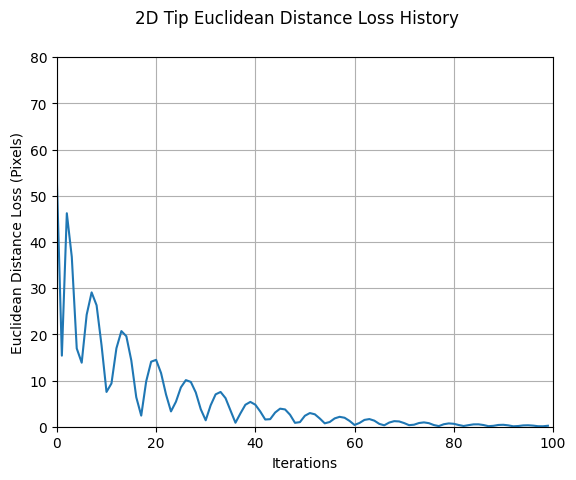

d3d_end_effector_loss_history:  [0.004442799836397171, 0.010480117052793503, 0.008365520276129246, 0.00894069205969572, 0.012126433663070202, 0.01396846305578947, 0.014578871428966522, 0.014924110844731331, 0.01615087501704693, 0.01878742128610611, 0.022434605285525322, 0.026209723204374313, 0.02929006516933441, 0.03122497908771038, 0.032014984637498856, 0.03200871869921684, 0.03173350542783737, 0.03172386810183525, 0.03234032541513443, 0.033654745668172836, 0.03549955040216446, 0.03756202384829521, 0.03947147727012634, 0.04093629866838455, 0.04185495525598526, 0.04231524467468262, 0.042517293244600296, 0.04268014803528786, 0.04296083375811577, 0.04340963065624237, 0.04397685080766678, 0.04456302896142006, 0.0450839065015316, 0.04551541432738304, 0.04589849337935448, 0.04630653187632561, 0.046796150505542755, 0.04736777022480965, 0.04795604199171066, 0.04845402389764786, 0.048761215060949326, 0.048835042864084244, 0.04872008413076401, 0.04853792116045952, 0.048439882695674896, 0.048542

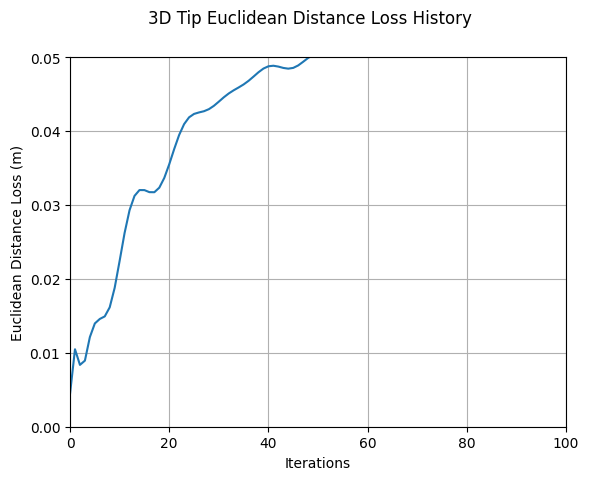

In [15]:
if __name__ == '__main__':
    '''
    Main function to set up optimzer model and run the optimization loop
    '''

    ###========================================================
    ### 1) SET TO GPU OR CPU COMPUTING
    ###========================================================
    if torch.cuda.is_available():
        gpu_or_cpu = torch.device("cuda:0") 
        torch.cuda.set_device(gpu_or_cpu)
    else:
        gpu_or_cpu = torch.device("cpu")

    ###========================================================
    ### 2) VARIABLES FOR BEZIER CURVE CONSTRUCTION
    ###========================================================
    # para_init = torch.tensor([0.02, 0.002, 0.0, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.0])


    # Z axis + 0.1
    # para_init = torch.tensor([0.02, 0.002, 0.1, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.1000])
        
    

    # p_start and para_init used for SRC presentation
    p_start = torch.tensor([0.02, 0.002, 0.000001]) # 0 here will cause NaN in draw2DCylinderImage, pTip
    # para_init = np.array([0.0365, 0.0036,  0.1202,  0.0056, -0.0166, 0.1645],
    #                  dtype=np.float32)
    para_init = np.array([0.025, 0.0025,  0.1202,  0.036, -0.0366, 0.18],
                     dtype=np.float32)

    # case_naming = '/Users/kobeyang/Downloads/Programming/ECESRIP/diff_catheter/scripts/test_diff_render_catheter_v2/blender_imgs/test_catheter_gt1'
    # case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/blender_imgs/test_catheter_gt1'
    case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/data/rendered_images/dof2_64/dof2_c48_0.001_-0.005_0.2_0.01'
    img_save_path = case_naming + '.png'
    cc_specs_path = case_naming + '_gt.npy'
    target_specs_path = None
    viewpoint_mode = 1
    transparent_mode = 0

    '''
    Create binary mask of catheter: 
        1) Grayscale the ref img, 
        2) threshold the grayscaled img, 
        3) Creates a binary image by replacing all 
            pixel values equal to 255 with 1 (leaves
            other pixel values unchanged)
    '''
    # img_ref_rgb = cv2.imread(img_save_path)
    # img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    # (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 80, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    img_ref_binary = process_image(img_save_path)

    # Declare loss history lists to keep track of loss values
    proj_end_effector_loss_history = []
    d3d_end_effector_loss_history = []
    # Ground Truth parameters for catheter used in SRC presentation
    para_gt_np = np.load(cc_specs_path)[1:3, :].flatten()
    para_gt = torch.tensor(para_gt_np, dtype=torch.float, device=gpu_or_cpu, requires_grad=False)
    # para_gt = torch.tensor([0.02003904, 0.0016096, 0.13205799, 0.00489567, -0.03695673, 0.196168896], dtype=torch.float, device=gpu_or_cpu, requires_grad=False)
    end_effector_gt = para_gt[3:6]
    
    folder_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/data/rendered_images/dof2_64/'
    image_save_path_list = [
    folder_path + 'dof2_c47_0.0005_0.005_0.2_0.01.png',
    folder_path + 'dof2_c46_0.0005_0.001_0.2_0.01.png',
    folder_path + 'dof2_c45_0.0005_0.0005_0.2_0.01.png'
    ]
    
    past_frames_list = []
    for path in image_save_path_list:
        past_frames_list.append(process_image(path))
    
    delta_u_list = [[0.0005, -0.01], [0, 0.004], [0, 0.0005]]

    


    ###========================================================
    ### 3) SET UP AND RUN OPTIMIZATION MODEL
    ###========================================================
    catheter_optimize_model = ReconstructionOptimizer(p_start, para_init, img_ref_binary, gpu_or_cpu, past_frames_list, delta_u_list, img_save_path, image_save_path_list).to(gpu_or_cpu)

    print("Model Parameters:")
    for name, param in catheter_optimize_model.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")

    optimizer = torch.optim.Adam(catheter_optimize_model.parameters(), lr=1e-2)

    # Run the optimization loop
    num_iterations = 100
    loop = tqdm(range(num_iterations))
    for loop_id in loop:
        print("\n================================================================================================================")
        print("loop_id: ", loop_id)


        # save_img_path = '/Users/kobeyang/Downloads/Programming/ECESRIP/diff_catheter/scripts/test_diff_render_catheter_v2/rendered_imgs/' \
        #     + 'render_' + str(loop_id) + '.jpg'
            
        save_img_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/rendered_imgs_new/' \
            + 'render_' + str(loop_id) + '.jpg'

        # pdb.set_trace()

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # Run the forward pass
        loss = catheter_optimize_model(save_img_path)

        # Print gradients for all parameters before backward pass
        print("Gradients BEFORE BACKWARD PASS:")
        for name, param in catheter_optimize_model.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient: {param.grad.norm().item()}")  # Print the norm of the gradient
            else:
                print(f"{name}: No gradient computed")

        # Run the backward pass
        loss.backward(retain_graph=True)

        # Print gradients for all parameters after backward pass
        print("Gradients AFTER BACKWARD PASS:")
        for name, param in catheter_optimize_model.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient: {param.grad.norm().item()}")
            else:
                print(f"{name}: No gradient computed")

        # Update the parameters
        optimizer.step()


        # Print and inspect the updated parameters
        for name, param in catheter_optimize_model.named_parameters():
            print(f"Parameter: {name}, Updated Value: {param.data}")


        # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
        proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
        d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

        # Update the progress bar
        loop.set_description('Optimizing')

        # Update the loss
        loop.set_postfix(loss=loss.item())

        print("Loss: ", loss.item())


    for name, param in catheter_optimize_model.named_parameters():
        param_numpy = param.data.cpu().numpy()
        filename = f"{name}.npy"
        np.save(filename, param_numpy)
        print(f"Saved {name} to {filename}")

    # Given array of values proj_end_effector_loss_history, create plot of loss vs. iterations
    iterations_x_axis_proj = list(range(len(proj_end_effector_loss_history)))
    print("proj_end_effector_loss_history: ", proj_end_effector_loss_history)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    fig1.suptitle('2D Tip Euclidean Distance Loss History')
    ax1.plot(iterations_x_axis_proj, proj_end_effector_loss_history)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Euclidean Distance Loss (Pixels)')
    ax1.set_xlim([0, len(proj_end_effector_loss_history)])
    ax1.set_ylim([0, 80])
    ax1.grid(True)
    plt.show()


    # Given array of values d3d_end_effector_loss_history, create plot of 3d loss vs. iterations
    iterations_x_axis_3d = list(range(len(d3d_end_effector_loss_history)))
    print("d3d_end_effector_loss_history: ", d3d_end_effector_loss_history)
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    fig2.suptitle('3D Tip Euclidean Distance Loss History')
    ax2.plot(iterations_x_axis_3d, d3d_end_effector_loss_history)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Euclidean Distance Loss (m)')
    ax2.set_xlim([0, len(d3d_end_effector_loss_history)])
    ax2.set_ylim([0, 0.05])
    ax2.grid(True)
    plt.show()

proj_end_effector_loss_history:  [53.25059579962598, 15.383968668087114, 46.208551003956025, 36.769755011211274, 16.945614488069396, 13.856864228899047, 24.231697289083446, 29.074759237067656, 26.28562509973485, 17.631698856928992, 7.530291721687653, 9.370047663514578, 16.982202699423837, 20.699154116242756, 19.588251609883933, 14.34329661418366, 6.389093240852547, 2.403728720717497, 9.813320804971871, 14.074188641439093, 14.475182262089161, 11.616531906668472, 6.978601290939238, 3.3121228478422107, 5.410730416891387, 8.51850436337493, 10.087983731395973, 9.6958388839769, 7.417716010218845, 3.7978056327019516, 1.391371699927523, 4.642752988643792, 7.007333133996459, 7.523974428210238, 6.185726232887028, 3.5191207914012756, 0.861015381726706, 2.8851831081139476, 4.7556504139272935, 5.369869140139076, 4.771987540061606, 3.2950156139356697, 1.561822071270536, 1.6337826683886807, 3.0717286623593445, 3.9094158841662114, 3.741934021059398, 2.600149365554797, 0.8403880831102594, 0.99452098715

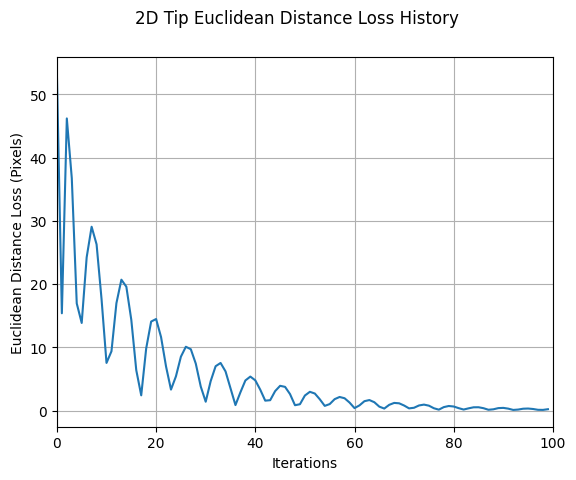

d3d_end_effector_loss_history:  [0.004442799836397171, 0.010480117052793503, 0.008365520276129246, 0.00894069205969572, 0.012126433663070202, 0.01396846305578947, 0.014578871428966522, 0.014924110844731331, 0.01615087501704693, 0.01878742128610611, 0.022434605285525322, 0.026209723204374313, 0.02929006516933441, 0.03122497908771038, 0.032014984637498856, 0.03200871869921684, 0.03173350542783737, 0.03172386810183525, 0.03234032541513443, 0.033654745668172836, 0.03549955040216446, 0.03756202384829521, 0.03947147727012634, 0.04093629866838455, 0.04185495525598526, 0.04231524467468262, 0.042517293244600296, 0.04268014803528786, 0.04296083375811577, 0.04340963065624237, 0.04397685080766678, 0.04456302896142006, 0.0450839065015316, 0.04551541432738304, 0.04589849337935448, 0.04630653187632561, 0.046796150505542755, 0.04736777022480965, 0.04795604199171066, 0.04845402389764786, 0.048761215060949326, 0.048835042864084244, 0.04872008413076401, 0.04853792116045952, 0.048439882695674896, 0.048542

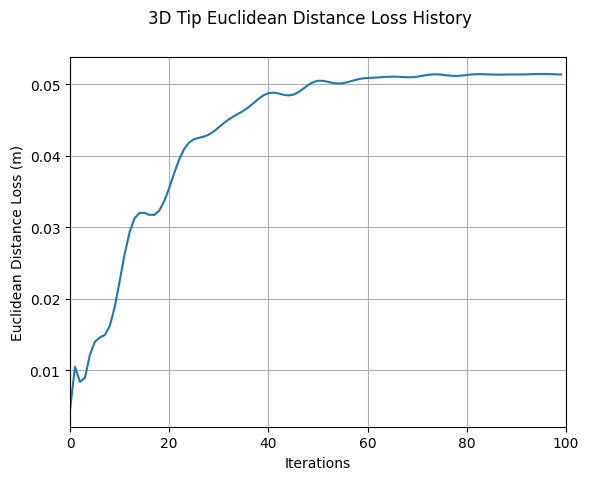

In [16]:
# Given array of values proj_end_effector_loss_history, create plot of loss vs. iterations
iterations_x_axis_proj = list(range(len(proj_end_effector_loss_history)))
print("proj_end_effector_loss_history: ", proj_end_effector_loss_history)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
fig1.suptitle('2D Tip Euclidean Distance Loss History')
ax1.plot(iterations_x_axis_proj, proj_end_effector_loss_history)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Euclidean Distance Loss (Pixels)')
ax1.set_xlim([0, len(proj_end_effector_loss_history)])
# ax1.set_ylim([0, 80])
ax1.grid(True)
plt.show()


# Given array of values d3d_end_effector_loss_history, create plot of 3d loss vs. iterations
iterations_x_axis_3d = list(range(len(d3d_end_effector_loss_history)))
print("d3d_end_effector_loss_history: ", d3d_end_effector_loss_history)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
fig2.suptitle('3D Tip Euclidean Distance Loss History')
ax2.plot(iterations_x_axis_3d, d3d_end_effector_loss_history)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Euclidean Distance Loss (m)')
ax2.set_xlim([0, len(d3d_end_effector_loss_history)])
# ax2.set_ylim([0, 0.05])
ax2.grid(True)
plt.show()